In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
import os
import zipfile
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [31]:
def extract_features(file_path, zip_file):
    with zip_file.open(file_path) as file:
        y, sr = librosa.load(file, sr=None)
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        S_DB = librosa.power_to_db(S, ref=np.max)
        return S_DB, sr

In [32]:
def plot_mel_spectrogram(S_DB, sr, title):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_DB, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()

In [40]:
zip_path = '/content/drive/MyDrive/Bird sound classification data/archive (1).zip'
metadata_path = '/content/drive/MyDrive/Bird sound classification data/bird_songs_metadata.csv'
metadata = pd.read_csv(metadata_path)


feature_list_mel = []
labels = []
file_paths = []

with zipfile.ZipFile(zip_path, 'r') as z:
    for index, row in metadata.iterrows():
        file_path = os.path.join('wavfiles', row['filename'])
        if file_path in z.namelist():
            S_DB,sr= extract_features(file_path, z)
            feature_list_mel.append(np.mean(S_DB, axis=1))  # Mel feature
            labels.append(row['species'])
            file_paths.append(file_path)

In [41]:

X_train_mel, X_test_mel, y_train, y_test, files_train, files_test = train_test_split(feature_list_mel, labels, file_paths, test_size=0.2, random_state=42)
scaler_mel = StandardScaler()
X_train_mel_scaled = scaler_mel.fit_transform(X_train_mel)
X_test_mel_scaled = scaler_mel.transform(X_test_mel)


label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_mel_scaled, y_train_encoded)
y_prob = knn.predict_proba(X_test_mel_scaled)

In [42]:
# test samples where the model is most confident
highest_prob_indices = np.argsort(-np.max(y_prob, axis=1))[:10]
print(highest_prob_indices)

[  0 399 400 809 808 403 405 398 806 408]


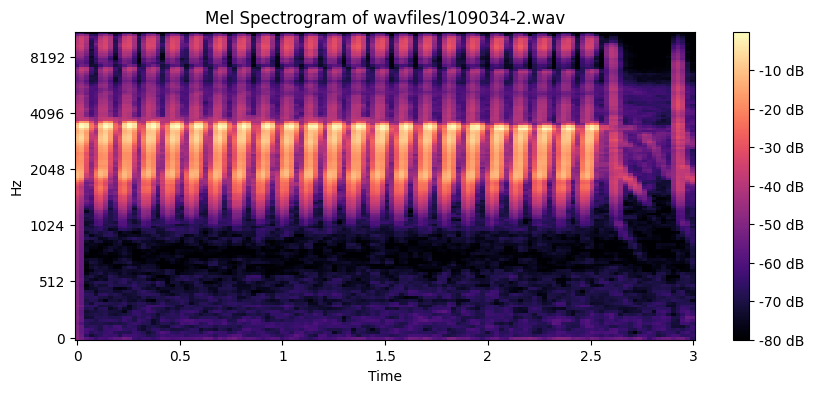

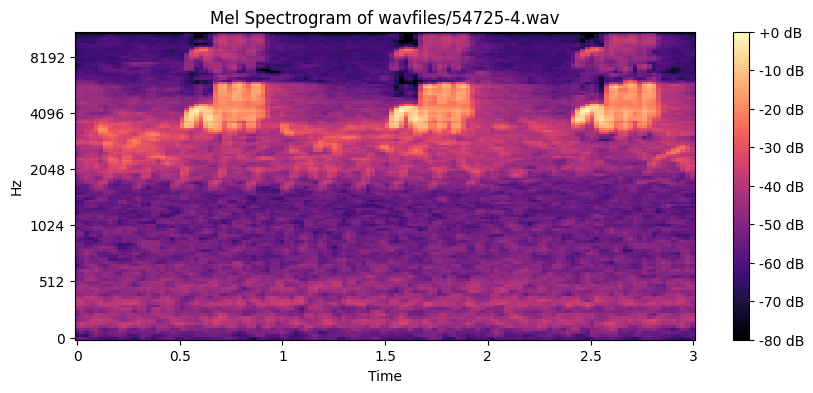

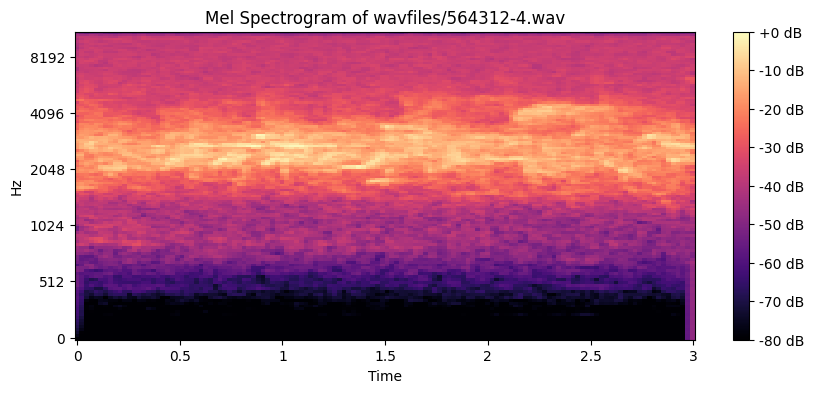

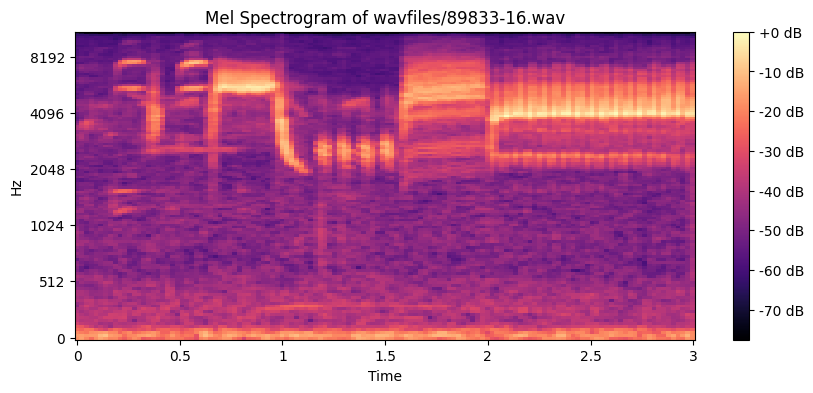

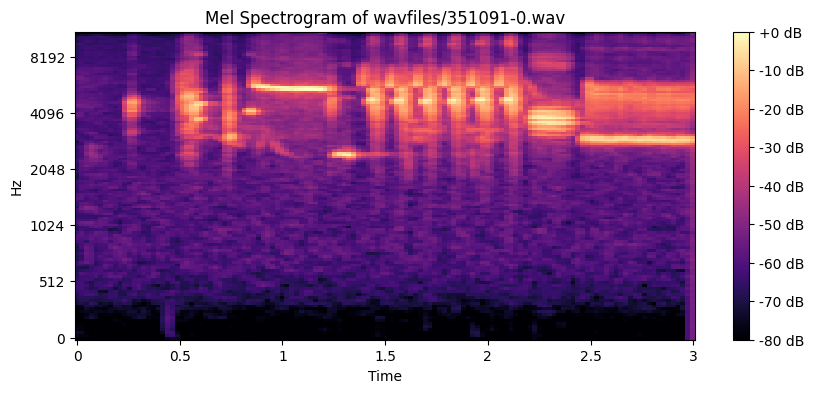

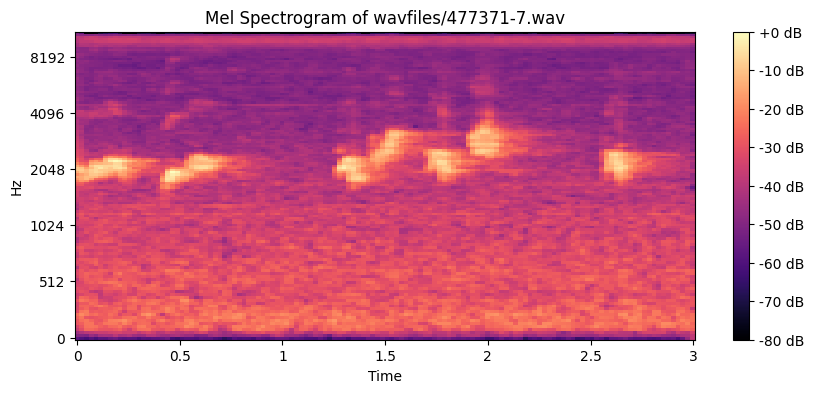

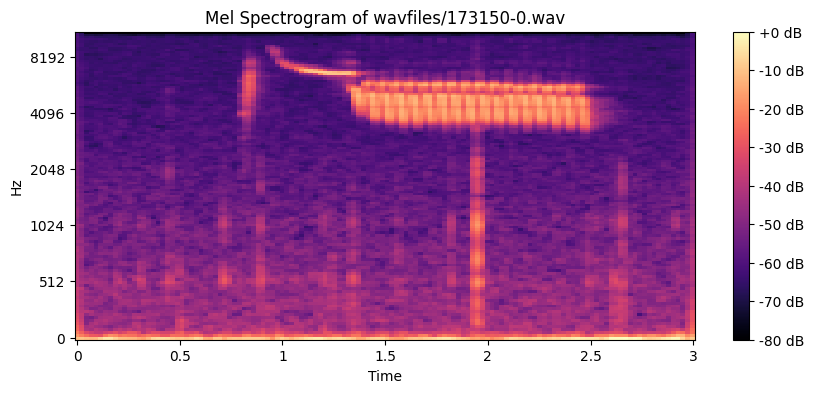

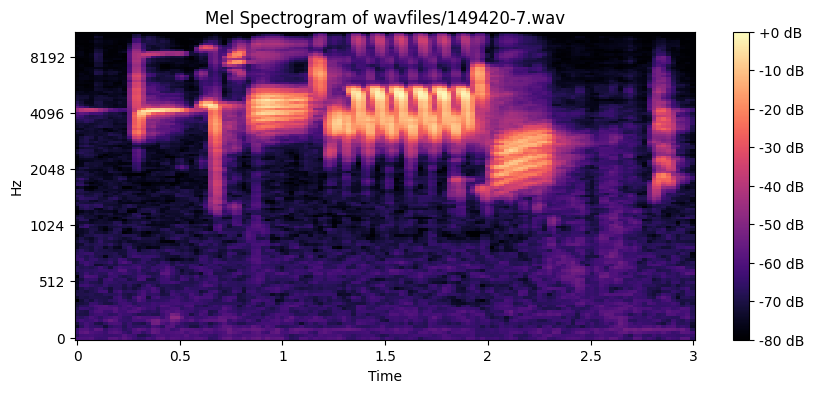

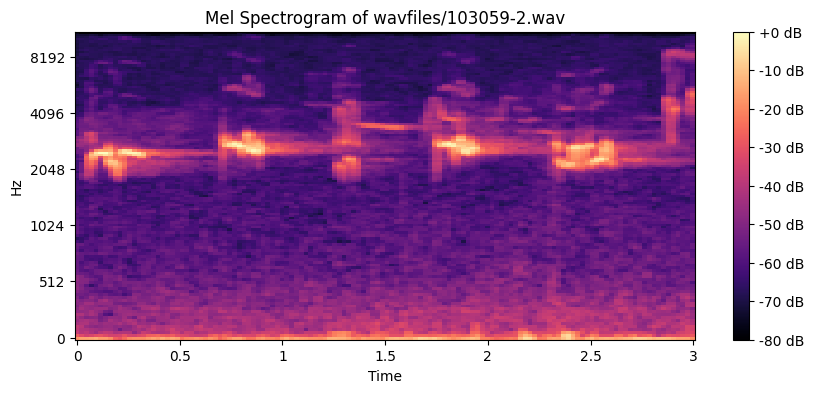

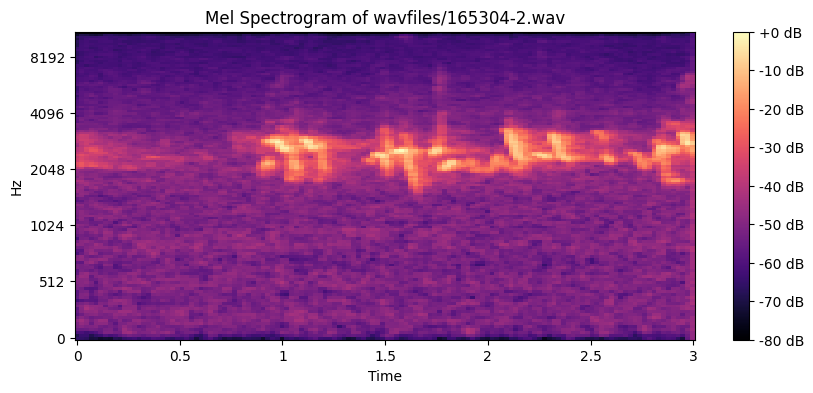

In [43]:
# extracting features and plotting
with zipfile.ZipFile(zip_path, 'r') as z:
    for index in highest_prob_indices:
        file_path = files_test[index]
        S_DB, sr = extract_features(file_path, z)
        plot_mel_spectrogram(S_DB, sr, f"Mel Spectrogram of {file_path}")

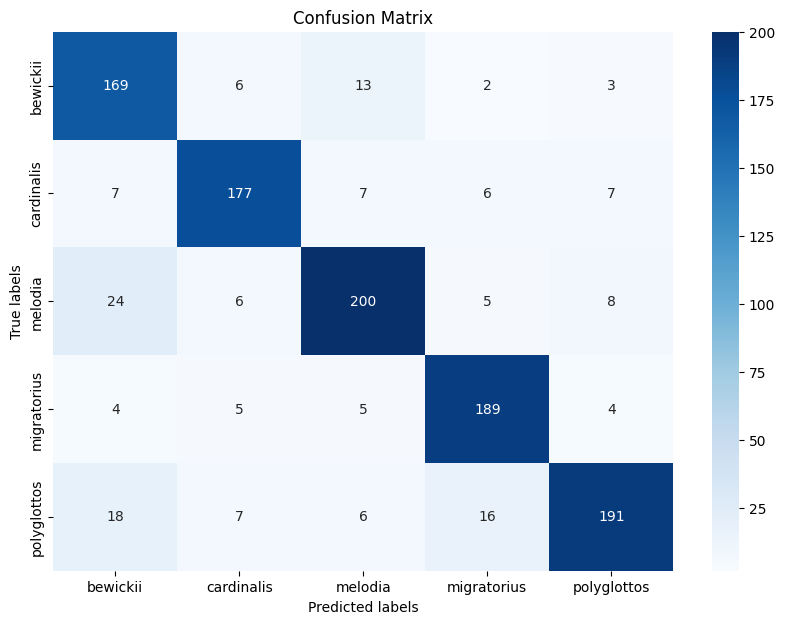

              precision    recall  f1-score   support

           0       0.76      0.88      0.81       193
           1       0.88      0.87      0.87       204
           2       0.87      0.82      0.84       243
           3       0.87      0.91      0.89       207
           4       0.90      0.80      0.85       238

    accuracy                           0.85      1085
   macro avg       0.85      0.86      0.85      1085
weighted avg       0.86      0.85      0.85      1085



In [44]:

y_pred_encoded = knn.predict(X_test_mel_scaled)
cm = confusion_matrix(y_test_encoded, y_pred_encoded)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
print(classification_report(y_test_encoded, y_pred_encoded))

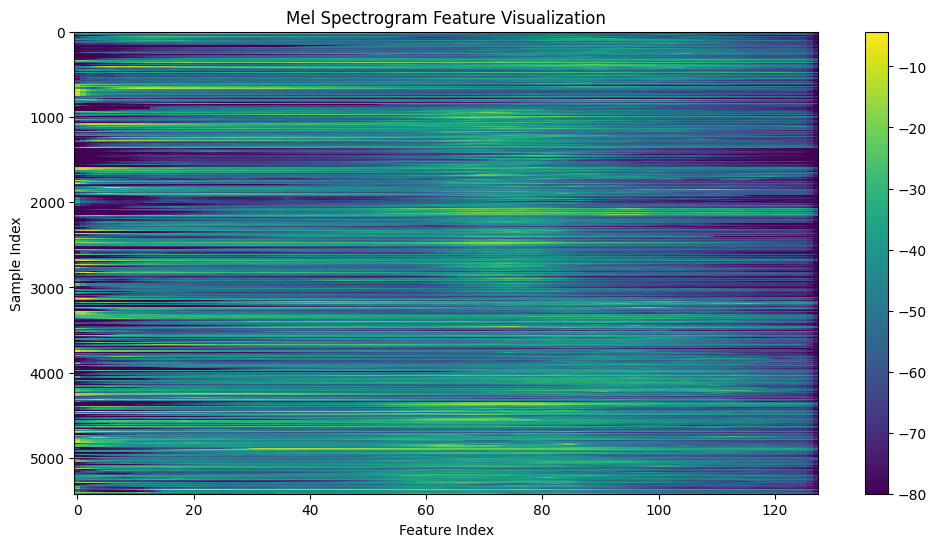

In [45]:
features_2D_mel = np.vstack(feature_list_mel)
plt.figure(figsize=(12, 6))
plt.imshow(features_2D_mel, aspect='auto', interpolation='nearest', cmap='viridis')
plt.colorbar()
plt.title('Mel Spectrogram Feature Visualization')
plt.xlabel('Feature Index')
plt.ylabel('Sample Index')
plt.show()